In [33]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import trapz
import os, sys
from astropy.io import fits
from astropy.table import Table
from drizzlepac import sky
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

In [34]:
# def compute_sky(input_image, n=100, good_frac=0.1, verbose=True):
#     image = fits.getdata(input_image, 'SCI')
#     flags = fits.getdata(input_image, 'FLAGS')
#     meds = []
#     for i in tqdm(range(0, image.shape[0]+n, n), disable=(not verbose)):
#         for j in range(0, image.shape[1]+n, n):
#             s1 = slice(i, i+n)
#             s2 = slice(j, j+n)
#             sub_im = image[s1, s2]
#             n_total = sub_im.shape[0] * sub_im.shape[1]
#             sub_mask = (flags[s1, s2] == 0)
#             data = sub_im[sub_mask]
#             data = data[~np.isnan(data)]
#             n_final = len(data)
#             if (n_final >= good_frac*n_total)&(n_final > 0):
#                 meds.append(np.median(data))
#     return np.min(meds)

In [35]:
# files = ['../data/NGC3377/reduced/NGC3377_F475W_drc.fits', '../data/NGC3377/reduced/NGC3377_F850LP_drc.fits',
#         '../data/NGC4993/reduced/NGC4993_F475W_drc.fits', '../data/NGC4993/reduced/NGC4993_F850LP_drc.fits',
#         '../data/M49/reduced/M49_F475W_drc.fits', '../data/M49/reduced/M49_F850LP_drc.fits',
#         '../data/M87/reduced/M87_F475W_drc.fits', '../data/M87/reduced/M87_F606W_drc.fits', '../data/M87/reduced/M87_F814W_drc.fits']

In [36]:
# for f in files:
#     sky = compute_sky(f, n=100, verbose=False)
#     print(f.rpartition('/')[-1], sky)

# Estimate Earthshine

scraped from http://www.stsci.edu/hst/stis/documents/handbooks/currentIHB/c06_exptime6.html#337664

In [37]:
df = pd.read_csv('../data/Earthshine_Levels.csv', names=['limbangle', 'mags'])
df.sort_values('limbangle', inplace=True)
limbangle, mags = df.values.T

In [38]:
mag_interp = interp1d(limbangle, mags, kind='cubic', fill_value='extrapolate')

In [39]:
def flux_ratio(angle, baseline=50, earth_mod=None):
    """
    Compute the flux ratio of Earthshine at angle, relative to 50 degrees
    """
    baseline = mag_interp(baseline)
    mags = earth_mod if earth_mod is not None else mag_interp(angle)
    fluxes = 10.**(-0.4 * (mags - baseline))
    return fluxes

Text(0, 0.5, 'EarthShine (V-band Mags / as^2)')

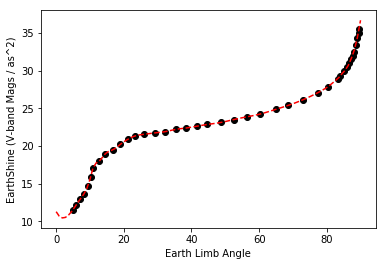

In [40]:
plt.plot(limbangle, mags, 'ko')
x = np.linspace(0, 90, 100)
plt.plot(x, mag_interp(x), 'r--')
plt.xlabel('Earth Limb Angle')
plt.ylabel('EarthShine (V-band Mags / as^2)')

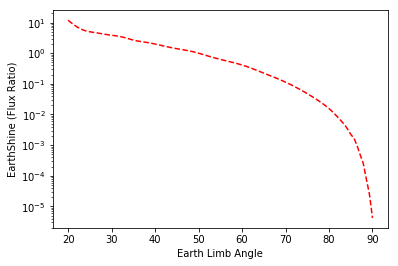

In [41]:
x = np.linspace(20, 90, 100)
plt.plot(x, flux_ratio(x), 'r--')
plt.xlabel('Earth Limb Angle')
plt.ylabel('EarthShine (Flux Ratio)')
plt.yscale('log')

In [42]:
def total_earthshine(angles, times=None, is_bright=None, earth_mod=None):
    """
    Return the total earthshine flux (relative to 50 degrees) over an exposure
    
    Assumes 3 second spacing between datapoints if x not given
    """
    fluxes = flux_ratio(angles, earth_mod=earth_mod)
    if is_bright is not None:
        fluxes *= is_bright.astype(float)
    kwargs = {'x': times}
    if times is None:
        kwargs['dx'] = 3.0
    return trapz(fluxes, **kwargs)

In [43]:
def earthshine_factor(flc_file):
    """
    Return the earthshine factor for an exposure, including both the average earthshine and the total exposure time
    """
    gal_name = flc_file.rpartition('/')[-1].split('_')[0]
    asn_id = fits.getval(flc_file, 'ASN_ID').lower()
    if asn_id == 'none':
        asn_id = fits.getval(flc_file, 'ROOTNAME').lower()[:-1] + 'j'
    root_name = fits.getval(flc_file, 'ROOTNAME').lower()[:-1]
    jit_file = f'../data/{gal_name}/calibration/{asn_id}_jit.fits'
    if not os.path.isfile(jit_file):
        jit_file = jit_file.replace('0_jit.fits', '1_jit.fits')
        if not os.path.isfile(jit_file):
            raise FileNotFoundError(f'No jit file found for {flc_file} under {jit_file}')
    with fits.open(jit_file) as h:
        for i in range(1, len(h)):
            if h[i].header['EXPNAME'].lower()[:-1] == root_name:
                if 'BrightLimb' in h[i].data.columns.names:
                    is_bright = h[i].data['BrightLimb']
                    earth_mod = None
                else:
                    is_bright = None
                    earth_mod = h[i].data['EarthMod']
                return total_earthshine(h[i].data['LIMBANG'], times=h[i].data['Seconds'],
                                        is_bright=is_bright, earth_mod=earth_mod)
    raise FileNotFoundError(f'No valid extension found for {root_name}')

In [44]:
def get_zodiacal_params(files, outputs):
    for filt in files.keys():
        print(filt)
        print('Filter 1', fits.getval(outputs[filt], 'FILTER1'))
        print('Filter 2', fits.getval(outputs[filt], 'FILTER2'))
        print('Exposure Time', fits.getval(outputs[filt], 'EXPTIME'), 's')
        print('RA', fits.getval(files[filt][0], 'RA_TARG'))
        print('DEC', fits.getval(files[filt][0], 'DEC_TARG'))
        for f in files[filt]:
            print('SUN ANGLE', fits.getval(f, 'SUNANGLE'))
        print('')

In [45]:
def total_sky(flcs, drc, no_earth_sky, avg_earth_sky, pix_scale=0.05):
    """
    Compute the total sky
    
    no_earth_sky : sky value without earthshine (in e-/s/as^2)
    avg_earth_sky : sky value with average earthshine (in e-/s/as^2)
    dark_current : dark current (in e-/s/as^2)
    """
    avg_earth_counts = (avg_earth_sky - no_earth_sky) * pix_scale**2
    zodiacal_sky = fits.getval(drc, 'EXPTIME') * (no_earth_sky) * pix_scale**2
    earth_sky = 0.
    for f in flcs:
        earth_sky += avg_earth_counts * earthshine_factor(f)
    print(f'Total Sky: {earth_sky + zodiacal_sky:.1f}')
    print(f'    Zodiacal: {zodiacal_sky:.1f}')
    print(f'    Earthshine: {earth_sky:.1f}')
    return earth_sky + zodiacal_sky

In [48]:
files, outputs = {}, {}

files['NGC4993'] = {'F475W': ['../data/NGC4993/raw/NGC4993_F475W_EXP{:d}_flc.fits'.format(i) for i in range(1, 4)],
                    'F850LP': ['../data/NGC4993/raw/NGC4993_F850LP_EXP{:d}_flc.fits'.format(i) for i in range(1, 3)]}
outputs['NGC4993'] = {'F475W': '../data/NGC4993/reduced/NGC4993_F475W_drc.fits',
                      'F850LP': '../data/NGC4993/reduced/NGC4993_F850LP_drc.fits'}

files['M87'] = {'F475W': ['../data/M87/raw/M87_F475W_EXP{:d}_flc.fits'.format(i) for i in range(1, 3)],
                'F606W': ['../data/M87/raw/M87_F606W_EXP{:d}_flc.fits'.format(i) for i in range(1, 7)],
                'F814W': ['../data/M87/raw/M87_F814W_EXP{:d}_flc.fits'.format(i) for i in range(1, 9)]}
outputs['M87'] = {'F475W': '../data/M87_v2/reduced/M87_F475W_drc.fits',
                  'F606W': '../data/M87/reduced/M87_F606W_drc.fits',
                  'F814W': '../data/M87/reduced/M87_F814W_drc.fits'}

files['M49'] = {'F475W': ['../data/M49/raw/M49_F475W_EXP{:d}_flc.fits'.format(i) for i in range(1, 3)],
                'F850LP': ['../data/M49/raw/M49_F850LP_EXP{:d}_flc.fits'.format(i) for i in range(1, 3)]}
outputs['M49'] = {'F475W': '../data/M49/reduced/M49_F475W_drc.fits',
                  'F850LP': '../data/M49/reduced/M49_F850LP_drc.fits'}

files['NGC3377'] = {'F475W': ['../data/NGC3377/raw/NGC3377_F475W_EXP{:d}_flc.fits'.format(i) for i in range(1, 5)],
                    'F850LP': ['../data/NGC3377/raw/NGC3377_F850LP_EXP{:d}_flc.fits'.format(i) for i in range(1, 5)]}
outputs['NGC3377'] = {'F475W': '../data/NGC3377/reduced/NGC3377_F475W_drc.fits',
                      'F850LP': '../data/NGC3377/reduced/NGC3377_F850LP_drc.fits'}

files['M51'] = {'F435W': ['../data/M51/raw/M51_F435W_EXP{:d}_flc.fits'.format(i) for i in range(1, 5)],
                'F814W': ['../data/M51/raw/M51_F814W_EXP{:d}_flc.fits'.format(i) for i in range(1, 5)]}
outputs['M51'] = {'F435W': '../data/M51/reduced/M51_F435W_drc.fits',
                  'F814W': '../data/M51/reduced/M51_F814W_drc.fits'}

files['DF2'] = {'F606W': ['../data/DF2/raw/DF2_F606W_EXP{:d}_flc.fits'.format(i) for i in range(1, 5)],
                'F814W': ['../data/DF2/raw/DF2_F814W_EXP{:d}_flc.fits'.format(i) for i in range(1, 5)]}
outputs['DF2'] = {'F606W': '../data/DF2/reduced/DF2_F606W_drc.fits',
                  'F814W': '../data/DF2/reduced/DF2_F814W_drc.fits'}

files['M31'] = {'F475W': [],
               'F814W': []}
outputs['M31'] = {'F475W': '../data/m31/raw/hlsp_phat_hst_acs-wfc_12058-m31-b01_f475w_v1_drz_ALIGNED.fits',
                  'F814W': '../data/m31/raw/hlsp_phat_hst_acs-wfc_12058-m31-b01_f814w_v1_drz.fits'}

In [49]:
no_earth_sky = {}
avg_earth_sky = {}

# NGC 3377

In [50]:
print('NGC3377')
get_zodiacal_params(files['NGC3377'], outputs['NGC3377'])

NGC3377
F475W
Filter 1 F475W
Filter 2 CLEAR2L
Exposure Time 1380.0 s
RA 161.9264166667
DEC 13.98563888889
SUN ANGLE 134.615356
SUN ANGLE 134.671051
SUN ANGLE 134.676132
SUN ANGLE 134.681183

F850LP
Filter 1 F850LP
Filter 2 CLEAR2L
Exposure Time 3005.0 s
RA 161.9264166667
DEC 13.98563888889
SUN ANGLE 134.739075
SUN ANGLE 134.747574
SUN ANGLE 134.804459
SUN ANGLE 134.814835



In [51]:
no_earth_sky['NGC3377'] = {
    'F850LP': 16.887,
    'F475W': 22.177
}
avg_earth_sky['NGC3377'] = {
    'F850LP': 20.873,
    'F475W': 29.207
}

# NGC 4993

In [52]:
print('NGC4993')
get_zodiacal_params(files['NGC4993'], outputs['NGC4993'])

NGC4993
F475W
Filter 1 F475W
Filter 2 CLEAR2L
Exposure Time 1395.0 s
RA 197.450375
DEC -23.38148611111
SUN ANGLE 52.592072
SUN ANGLE 52.537567
SUN ANGLE 52.583733

F850LP
Filter 1 F850LP
Filter 2 CLEAR2L
Exposure Time 680.0 s
RA 197.450375
DEC -23.38148611111
SUN ANGLE 52.410385
SUN ANGLE 52.46376



In [53]:
no_earth_sky['NGC4993'] = {
    'F850LP': 33.574,
    'F475W': 43.99
}
avg_earth_sky['NGC4993'] = {
    'F850LP': 37.561,
    'F475W': 51.018
}

# M87

In [54]:
print('M87')
get_zodiacal_params(files['M87'], outputs['M87'])

M87
F475W
Filter 1 F475W
Filter 2 CLEAR2L
Exposure Time 750.0 s
RA 187.7059166667
DEC 12.39111111111
SUN ANGLE 116.435112
SUN ANGLE 116.441307

F606W
Filter 1 F606W
Filter 2 CLEAR2L
Exposure Time 3000.0 s
RA 187.7058333333
DEC 12.39111111111
SUN ANGLE 108.552048
SUN ANGLE 115.290573
SUN ANGLE 123.160904
SUN ANGLE 130.668259
SUN ANGLE 137.063354
SUN ANGLE 143.136826

F814W
Filter 1 CLEAR1L
Filter 2 F814W
Exposure Time 2880.0 s
RA 187.7058333333
DEC 12.39111111111
SUN ANGLE 108.488235
SUN ANGLE 108.495064
SUN ANGLE 108.500923
SUN ANGLE 108.50679
SUN ANGLE 115.219025
SUN ANGLE 115.225822
SUN ANGLE 115.279114
SUN ANGLE 115.284943



In [55]:
no_earth_sky['M87'] = {
    'F814W': 40.57,
    'F606W': 46.818,
    'F475W': 20.167,
}
avg_earth_sky['M87'] = {
    'F814W': 50.356,
    'F606W': 58.919,
    'F475W': 27.197
}

# M49

In [56]:
print('M49')
get_zodiacal_params(files['M49'], outputs['M49'])

M49
F475W
Filter 1 F475W
Filter 2 CLEAR2L
Exposure Time 750.0 s
RA 187.4449583333
DEC 8.000416666667
SUN ANGLE 96.026253
SUN ANGLE 96.020294

F850LP
Filter 1 F850LP
Filter 2 CLEAR2L
Exposure Time 1120.0 s
RA 187.4449583333
DEC 8.000416666667
SUN ANGLE 96.041382
SUN ANGLE 96.033813



In [57]:
no_earth_sky['M49'] = {
    'F850LP': 20.317,
    'F475W': 26.694
}
avg_earth_sky['M49'] = {
    'F850LP': 24.303,
    'F475W': 33.724
}

# M51

In [58]:
print('M51')
get_zodiacal_params(files['M51'], outputs['M51'])

M51
F435W
Filter 1 CLEAR1L
Filter 2 F435W
Exposure Time 2720.0 s
RA 202.5075833333
DEC 47.21459444444
SUN ANGLE 111.699074
SUN ANGLE 112.143326
SUN ANGLE 111.138313
SUN ANGLE 112.656525

F814W
Filter 1 CLEAR1L
Filter 2 F814W
Exposure Time 1360.0 s
RA 202.5075833333
DEC 47.21459444444
SUN ANGLE 111.70826
SUN ANGLE 112.152435
SUN ANGLE 111.147583
SUN ANGLE 112.665565



In [59]:
no_earth_sky['M51'] = {
    'F814W': 21.43,
    'F435W': 5.960
}
avg_earth_sky['M51'] = {
    'F814W': 32.19,
    'F435W': 9.816
}

# DF2

DF2 is not an extended source, so astrodrizzle's Sky should work well

In [60]:
sky_F814W = Table(fits.getdata(outputs['DF2']['F814W'], 'HDRTAB')).to_pandas().MDRIZSKY.sum() / 2.
sky_F606W = Table(fits.getdata(outputs['DF2']['F606W'], 'HDRTAB')).to_pandas().MDRIZSKY.sum() / 2.

In [61]:
sky_F814W, sky_F606W

(163.67780303955078, 207.13434600830078)

In [62]:
print('DF2')
get_zodiacal_params(files['DF2'], outputs['DF2'])

DF2
F606W
Filter 1 F606W
Filter 2 CLEAR2L
Exposure Time 2180.0 s
RA 40.44466666667
DEC -8.403
SUN ANGLE 150.606979
SUN ANGLE 150.601379
SUN ANGLE 150.595551
SUN ANGLE 150.59053

F814W
Filter 1 CLEAR1L
Filter 2 F814W
Exposure Time 2320.0 s
RA 40.44466666667
DEC -8.403
SUN ANGLE 150.567093
SUN ANGLE 150.561432
SUN ANGLE 150.555328
SUN ANGLE 150.550049



In [63]:
no_earth_sky['DF2'] = {
    'F814W': 32.3,
    'F606W': 38.642
}
avg_earth_sky['DF2'] = {
    'F814W': 43.059,
    'F606W': 53.581
}

# M31

In [69]:
no_earth_sky['M31'] = {
    'F814W': 23.429,
    'F475W': 12.039
}
avg_earth_sky['M31'] = {
    'F814W': 34.188,
    'F475W': 19.07
}

# Results

In [70]:
for gal in files.keys():
    print('========')
    print(gal)
    for filt in files[gal].keys():
        print(filt)
        total_sky(files[gal][filt], outputs[gal][filt], no_earth_sky[gal][filt], avg_earth_sky[gal][filt])
    print('')

NGC4993
F475W
Total Sky: 157.1
    Zodiacal: 153.4
    Earthshine: 3.7
F850LP
Total Sky: 58.5
    Zodiacal: 57.1
    Earthshine: 1.4

M87
F475W
Total Sky: 43.4
    Zodiacal: 37.8
    Earthshine: 5.6
F606W
Total Sky: 377.1
    Zodiacal: 351.1
    Earthshine: 26.0
F814W
Total Sky: 292.8
    Zodiacal: 292.1
    Earthshine: 0.7

M49
F475W
Total Sky: 50.1
    Zodiacal: 50.1
    Earthshine: 0.0
F850LP
Total Sky: 56.9
    Zodiacal: 56.9
    Earthshine: 0.0

NGC3377
F475W
Total Sky: 76.5
    Zodiacal: 76.5
    Earthshine: 0.0
F850LP
Total Sky: 126.9
    Zodiacal: 126.9
    Earthshine: 0.0

M51
F435W
Total Sky: 40.5
    Zodiacal: 40.5
    Earthshine: 0.0
F814W
Total Sky: 72.9
    Zodiacal: 72.9
    Earthshine: 0.0

DF2
F606W
Total Sky: 210.6
    Zodiacal: 210.6
    Earthshine: 0.0
F814W
Total Sky: 187.3
    Zodiacal: 187.3
    Earthshine: 0.0

M31
F475W


KeyError: "Keyword 'EXPTIME' not found."